## 02. Using the GALACTICNUCLEUS catalog

This script aims to simulate a spectral image that would be observed using slitless spectroscopy, using the data on the star position and flux as was obtained from the GALACTICNUCLEUS survey. The original publication can be found [here](https://www.aanda.org/articles/aa/full_html/2019/11/aa36263-19/aa36263-19.html#S2) and the data can also be downloaded from [here](http://cdsarc.unistra.fr/viz-bin/cat/J/A+A/631/A20). 

Script written by: **Soumya Shreeram** <br/> 
Project supervised by: **Francisco Nogueras-Lara and Nadine Neumayer (MPIA)** <br/>
Date: **05th October 2020** <br/>

In [1]:
import astropy.io.fits as fits
from scipy.sparse import csr_matrix
import scipy.stats as stats
import numpy as np
import os
import importlib

# generate random integer values
from random import seed
from random import randint

# plotting imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm

# to show progress during computations
from time import sleep
import sys

import matplotlib

In [2]:
%matplotlib inline
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

Personal imports

In [15]:
sys.path.append('imported_files/')
import Simulating_Spectra as ss
import plotting as pt

#### 1. Defining input parameters

In [18]:
# setting up the working directory path
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "Data")

# putting together the file name
string_name = 'J_A+A_631_A20_central.dat.fits'
filename = os.path.join(data_dir, string_name)

# region of the sky into which we zoom in
de_ll, de_ul = -29.04, -29.06
ra_ll, ra_ul =  266.51, 266.52

# temporary variable to select number of stars
max_stars = 1000

# FOV in pixels
l_pix, u_pix = 0, 2000


In [7]:
def readCatalogFile(filename):
    """
    Function to read the magnitude and positions of the stars from the catalog file
    """
    hdu_list = fits.open(filename)
    # Ks band magnitude
    mag_Ks = hdu_list[1].data['Ksmag']

    # position of stars in the sky
    ra_Ks = hdu_list[1].data['RAKsdeg']
    de_Ks = hdu_list[1].data['DEKsdeg']

    # errors on magnitude and positions
    e_mag_Ks = hdu_list[1].data['e_Ksmag']
    e_ra_Ks = hdu_list[1].data['e_RAKsdeg']
    e_de_Ks = hdu_list[1].data['e_DEKsdeg']
    
    # close file
    hdu_list.close()
    
    errors = [e_mag_Ks, e_ra_Ks, e_de_Ks]
    return mag_Ks, ra_Ks, de_Ks, errors

def chooseFewStars(de_ll, de_ul, de_Ks):
    """
    Function selects stars in the given region of the sky
    @ra_ll, de_ll :: right ascension and declination lower limits (ll)
    @ra_ul, de_ul :: right ascension and declination upper limits (ul)
    """
    de_idx_array = []
    
    # select desired dec coordinates
    for m, de in enumerate(de_Ks):
        if de < de_ll and de > de_ul:
            de_idx_array.append(m)
    
    print('Choosing %.2f percent stars from %d total stars'%((len(de_idx_array)/len(de_Ks))*100, len(de_Ks)))
    return de_idx_array

def shortenXYaxisTicks(ax):
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    return

In [8]:
mag_Ks, ra_Ks, de_Ks, errors = readCatalogFile(filename)

# choose a few stars in the sky for analysis
de_idx_array = chooseFewStars(de_ll, de_ul, de_Ks)
mag_Ks, ra_Ks, de_Ks = mag_Ks[de_idx_array], ra_Ks[de_idx_array], de_Ks[de_idx_array]

Choosing 3.09 percent stars from 2009522 total stars


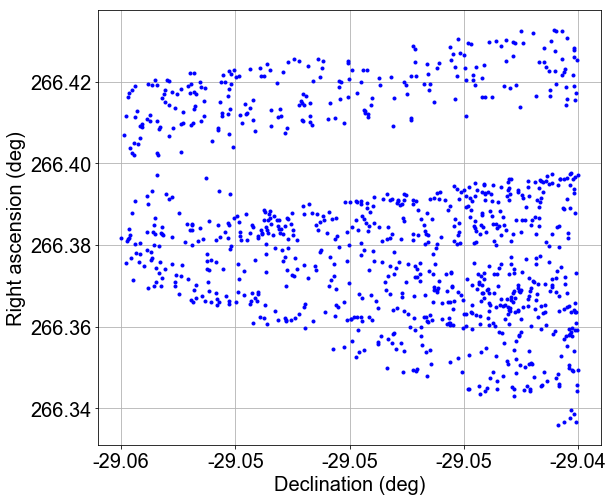

In [17]:
fig, ax = plt.subplots(1,1,figsize=(9,8))

# plotting the stars
ax.plot(de_Ks[0:max_stars], ra_Ks[0:max_stars], "b.")
pt.setLabel(ax, 'Declination (deg)', 'Right ascension (deg)', '', 'default', 'default', legend=False)

shortenXYaxisTicks(ax)

In [25]:
flux_matrix2D = csr_matrix((mag_Ks, (ra_Ks, np.abs(de_Ks))), shape=(u_pix, u_pix)).toarray()

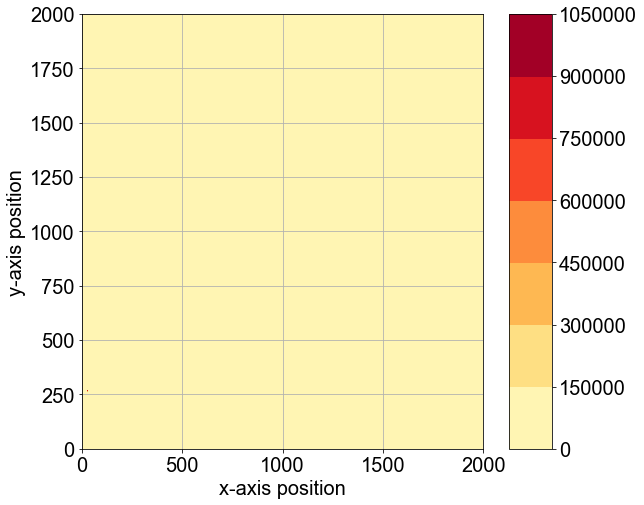

In [26]:
mag_Ks = mag_Ks.reshape()

In [29]:
np.shape(flux_matrix2D)

(2000, 2000)